# Summary
Needs to be cleaned up!

Generates a MapInfo File with hexagons and their stats.

Uses the custom geometry which splits the hexagons along city borders
and subsequently merges small and medium (PCCLASS 2,3) cities into single 
areas. (Which is a file output from elsewhere, technically could be computed
here as well). 

It combines the above against tiles from the Ookla dataset. This 
is done by calculating the spatial join (GeoPandas sjoin()) on the 
default "intersection" predicate. This allows some tiles 
to contribute to multiple hexagons if they partially overlap more 
than one area.

After computing tile/hexagon intersection, the most recent 4 quarters 
are selected for calculating speed statistics. For many (rural) areas
there are no or few tiles from this; so an expanding 
selection is done to try and get better stats in these areas by 
verifying the sum of tests in the area are at least 10, 
adding first the remainder of the "fixed" data tiles for 
earlier quarter, then all tiles tiles (including mobile tiles)
if that still does not give at least 10 tests. 



In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport src.datasets.joins
%aimport src.datasets.loading.statcan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from src.datasets.loading import statcan
from src.datasets.loading import ookla
from src.datasets import overlays

import statsmodels as sm
# import statsmodels.stats.weightstats
from scipy.stats import lognorm

import src.config
from pathlib import Path
import geopandas as gp
import src.datasets.joins as joins

import re

/Users/zacharyshand/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
output_name = "LastFourQuartersOrBestEstimate_On_DissolvedSmallerCitiesHexes"
output_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries"
output_dir.mkdir(exist_ok=True)

In [3]:
CRS = 'EPSG:4326'

In [4]:
popctrs = statcan.boundary('population_centres')

In [5]:
derived_geometry = (Path(src.config.DATA_DIRECTORY) / 'processed' / 'geometries').resolve()

speed_data = gp.read_file(derived_geometry / 'hexagons_w_dissolved_smaller_popctrs.geojson')#, driver='GeoJSON')
#speed_data = speed_data.to_crs(CRS)
# speed_data.crs = popctrs.crs #assign crs b/c geojson assumes GPS/epsg:4326
speed_data = speed_data.dropna(subset=['HEXUID_PCPUID'])

In [6]:
speed_data.head(2)

,PCPUID,pc_area,hex_area,hex_frac,pc_frac,HEXUID_PCPUID,PRCODE,PCNAME,PCCLASS,Pop2016,...,URDwell2016_RH2016,PHH_Count,Common_Type,Pop2016_at_50_10_Combined,TDwell2016_at_50_10_Combined,URDwell_at_50_10_Combined,Pop_Avail_50_10,TDwell_Avail_50_10,URDwell_Avail_50_10,geometry
0,100792,1.719773e+08,2.539316e+07,0.440441,0.065033,NL47580528-100792,NL,St. John's,4,9896.147562,...,4318.056742,685.0,3.0,9860.925340,5043.554316,4304.723408,99.644081,99.707853,99.691219,"MULTIPOLYGON (((-52.78788 47.56551, -52.78288 ..."
1,100792,1.719773e+08,2.539316e+07,0.514429,0.075958,NL47580529-100792,NL,St. John's,4,4252.819048,...,1558.259524,437.0,4.0,4252.819048,1648.265873,1558.259524,100.000000,100.000000,100.000000,"POLYGON ((-52.90996 47.56425, -52.90990 47.564..."


In [7]:
tiles = ookla.canada_speed_tiles()#.loc[lambda s:(s.year==2022 ) & (s.conn_type=='fixed')]
tiles = tiles.to_crs(CRS)

In [8]:
unique_tiles = tiles[['quadkey','geometry']].drop_duplicates()
unique_tiles = unique_tiles.sjoin(speed_data[['HEXUID_PCPUID','geometry']].to_crs(tiles.crs))
unique_tiles = unique_tiles.drop(['index_right'],axis=1)

In [9]:
tiles = tiles.merge(unique_tiles.drop(['geometry'],axis=1), on='quadkey')

In [10]:
tiles.head(2)

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter,HEXUID_PCPUID
0,302312221203002,"POLYGON ((-72.72949 45.42544, -72.72400 45.425...",79946,34351,14,2,1,fixed,2019,3,240328
1,302312221203002,"POLYGON ((-72.72949 45.42544, -72.72400 45.425...",410409,440056,4,1,1,fixed,2019,4,240328


# Questions:
1. How many hex/areas are missing ookla tests/tiles from the last year (or X quarters)?
2. Can we selectively go back to older tiles to fill in areas with no tests in last time period?
3. Can we back fill older tiles/tests in areas with low test counts?

In [11]:
populated_areas = speed_data.loc[lambda s:s.Pop2016 > 0, 'HEXUID_PCPUID']
populated_areas

0         NL47580528-100792
1         NL47580529-100792
3         NL47430528-100792
4         NL47510528-100792
5         NL47510529-100792
                ...        
518037           BC59731291
518077           BC55711204
518078           BC55831204
518079           BC56311204
518087           BC53451204
Name: HEXUID_PCPUID, Length: 52923, dtype: object

In [12]:
areas = len(populated_areas)
areas

52923

In [13]:
areas_with_tiles = len(tiles.loc[lambda s:s.HEXUID_PCPUID.isin(populated_areas)].drop_duplicates(subset=['HEXUID_PCPUID']))
areas_with_tiles 

40809

In [14]:
areas_with_tiles_2022 = len(tiles.loc[lambda s:s.HEXUID_PCPUID.isin(populated_areas)].loc[lambda s:s.year == 2022].drop_duplicates(subset=['HEXUID_PCPUID']))
areas_with_tiles_2022

33179

In [15]:
areas_with_tiles/len(populated_areas)

0.7711014114846098

In [16]:
areas_with_tiles_2022/len(populated_areas)

0.6269296903047824

In [17]:
tiles.loc[lambda s:s.HEXUID_PCPUID.isin(populated_areas)].sort_values(by=['conn_type']).sort_values(by=['year','quarter'], ascending=False).drop_duplicates(subset='HEXUID_PCPUID')[['year','quarter','conn_type']].value_counts(normalize=True)

year  quarter  conn_type
2022  3        fixed        0.652699
      2        fixed        0.081894
      1        fixed        0.038398
2021  4        fixed        0.029601
      3        fixed        0.025313
2022  3        mobile       0.024039
2021  2        fixed        0.015634
      1        fixed        0.013012
2020  3        fixed        0.010684
      2        fixed        0.010414
2022  2        mobile       0.010120
2021  3        mobile       0.008920
2020  4        fixed        0.008895
      1        fixed        0.007645
2019  4        fixed        0.007033
2021  4        mobile       0.006812
2022  1        mobile       0.005881
2019  3        fixed        0.005513
      2        fixed        0.005415
2021  2        mobile       0.004852
2019  1        fixed        0.004631
2020  3        mobile       0.003945
2021  1        mobile       0.003700
2020  4        mobile       0.003259
2019  3        mobile       0.002744
2020  2        mobile       0.002573
      1      

In [18]:
# areas where last 4 quarters have at least 10 tests on fixed connections
# take all quarters on fixed tiles with at least 10 tests on fixed connections
# use all tiles

In [19]:
tests_in_last_4quarters = tiles.loc[lambda s:(s.year==2022) | ( (s.year==2021) & (s.quarter==4) )].loc[lambda s:s.conn_type=='fixed'].groupby('HEXUID_PCPUID')['tests'].sum()
tests_in_last_4quarters

HEXUID_PCPUID
100046        761
100072        209
100082        870
100084        536
100107        368
             ... 
YT64431406     21
YT66121372      7
YT66371367      1
YT67531398      2
YT67571399      3
Name: tests, Length: 37989, dtype: int64

In [20]:
level_1_areas = tests_in_last_4quarters.index[tests_in_last_4quarters > 10].dropna()
level_1_areas

Index(['100046', '100072', '100082', '100084', '100107', '100136', '100155',
       '100182', '100204', '100219',
       ...
       'YT62631372', 'YT63591359', 'YT64011392', 'YT64011393', 'YT64051390',
       'YT64051393', 'YT64051394', 'YT64091391', 'YT64091394', 'YT64431406'],
      dtype='object', name='HEXUID_PCPUID', length=23612)

In [21]:
fixed_tests_counts_nolevel1 = tiles.loc[lambda s:~s.HEXUID_PCPUID.isin(level_1_areas)].loc[lambda s:s.conn_type == 'fixed'].groupby('HEXUID_PCPUID')['tests'].sum()
fixed_tests_counts_nolevel1

HEXUID_PCPUID
241472        1711
241491           4
471420          47
621392           9
621393           2
              ... 
YT64161405       2
YT66121372       7
YT66371367       1
YT67531398       2
YT67571399       3
Name: tests, Length: 22336, dtype: int64

In [22]:
level_2_areas = fixed_tests_counts_nolevel1.index[fixed_tests_counts_nolevel1 > 10].dropna()
level_2_areas

Index(['241472', '471420', 'AB49051117', 'AB49051128', 'AB49051132',
       'AB49051133', 'AB49051135', 'AB49071118', 'AB49071119', 'AB49071136',
       ...
       'YT60891355', 'YT61021352', 'YT61551323', 'YT62011325', 'YT62231333',
       'YT62371334', 'YT62371409', 'YT63631387', 'YT63891353', 'YT64011358'],
      dtype='object', name='HEXUID_PCPUID', length=6594)

In [23]:
level_3_areas = tiles.drop_duplicates(subset='HEXUID_PCPUID').loc[lambda s:~s.HEXUID_PCPUID.isin(level_1_areas) & ~s.HEXUID_PCPUID.isin(level_2_areas)].HEXUID_PCPUID.dropna().values
level_3_areas

array(['NL49510553', 'SK51061059', 'SK53701091', ..., 'NS44820630',
       'NL47090559', 'NL47280528'], dtype=object)

In [25]:
l1_tiles = tiles.loc[lambda s:s.HEXUID_PCPUID.isin(level_1_areas)].loc[lambda s:(s.year==2022) | ( (s.year==2021) & (s.quarter==4) )].loc[lambda s:s.conn_type=='fixed']
l2_tiles = tiles.loc[lambda s:s.HEXUID_PCPUID.isin(level_2_areas)].loc[lambda s:s.conn_type=='fixed']
l3_tiles = tiles.loc[lambda s:s.HEXUID_PCPUID.isin(level_3_areas)]

selected_tiles = pd.concat([l1_tiles, l2_tiles, l3_tiles]).drop_duplicates(subset=['quadkey','conn_type','year','quarter'])
selected_tiles

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter,HEXUID_PCPUID
6,302312221203002,"POLYGON ((-72.72949 45.42544, -72.72400 45.425...",35992,10780,12,5,4,fixed,2021,4,240328
7,302312221203002,"POLYGON ((-72.72949 45.42544, -72.72400 45.425...",67907,8983,12,6,3,fixed,2022,2,240328
26,302230331100310,"POLYGON ((-81.70532 43.56447, -81.69983 43.564...",56176,60976,2,7,7,fixed,2021,4,351499
27,302230331100310,"POLYGON ((-81.70532 43.56447, -81.69983 43.564...",9972,3613,3,1,1,fixed,2022,1,351499
28,302230331100310,"POLYGON ((-81.70532 43.56447, -81.69983 43.564...",75419,69597,3,15,5,fixed,2022,2,351499
...,...,...,...,...,...,...,...,...,...,...,...
4592589,303300132012310,"POLYGON ((-54.01978 48.18074, -54.01428 48.180...",697,143,73,1,1,mobile,2022,3,NL48160540
4592591,303300223220320,"POLYGON ((-55.87646 47.07760, -55.87097 47.077...",68379,2644,56,1,1,mobile,2022,3,NL47090559
4592595,303301000333313,"POLYGON ((-53.09143 48.70184, -53.08594 48.701...",3561,1269,406,1,1,mobile,2022,3,NL48710531
4592596,303301002212003,"POLYGON ((-53.34412 48.54207, -53.33862 48.542...",3659,215,82,1,1,mobile,2022,3,NL48540534


In [27]:
speed_data = joins.add_simple_stats(speed_data, selected_tiles, 'HEXUID_PCPUID')

/Users/zacharyshand/ookla-statcan-analysis/notebooks/../src/datasets/joins.py:95: UserWarning: Tiles already have labels matching HEXUID_PCPUID, skipping labelling.
  warnings.warn(f"Tiles already have labels matching {geom_index}, skipping labelling.")


In [28]:
speed_data[pd.isna(speed_data.num_tiles)]

,PCPUID,pc_area,hex_area,hex_frac,pc_frac,HEXUID_PCPUID,PRCODE,PCNAME,PCCLASS,Pop2016,...,25p_u_kbps,50p_u_kbps,75p_u_kbps,max_u_kbps,avg_lat_ms,tests,ave_tests_per_tile,unique_devices,ave_devices_per_tile,num_tiles
2,100792,1.719773e+08,2.536795e+07,0.000288,0.000043,NL47710527-100792,NL,St. John's,4,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100792,1.719773e+08,2.538862e+07,0.000412,0.000061,NL47610528-100792,NL,St. John's,4,12.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,100792,1.719773e+08,2.541990e+07,0.002747,0.000406,NL47460528-100792,NL,St. John's,4,12.818182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,120348,2.605981e+08,2.606873e+07,0.109995,0.011003,NS44600636-120348,NS,Halifax,4,532.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,120348,2.605981e+08,2.601126e+07,0.025895,0.002585,NS44840637-120348,NS,Halifax,4,46.444444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518090,None,NaN,2.441105e+07,1.000000,NaN,BC53331204,BC,None,None,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518091,None,NaN,2.447289e+07,1.000000,NaN,BC52891204,BC,None,None,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518092,None,NaN,2.450451e+07,1.000000,NaN,BC52661204,BC,None,None,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518093,None,NaN,2.444205e+07,1.000000,NaN,BC53111204,BC,None,None,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
speed_data = joins.add_50_10_stats(speed_data, selected_tiles, 'HEXUID_PCPUID')

/Users/zacharyshand/ookla-statcan-analysis/notebooks/../src/datasets/joins.py:95: UserWarning: Tiles already have labels matching HEXUID_PCPUID, skipping labelling.
  warnings.warn(f"Tiles already have labels matching {geom_index}, skipping labelling.")


In [30]:
unused_columns = ['pc_area','hex_area','pc_frac', 'hex_frac']
for col in unused_columns:
    del speed_data[col]

speed_data['ookla_50_10_percentile'] = speed_data.apply(lambda s:min(s['50_down_percentile'], s['10_up_percentile']), axis=1)

In [31]:
speed_data.columns

Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'geometry', 'avg_d_kbps', 'std_d_kbps',
       'min_d_kbps', '25p_d_kbps', '50p_d_kbps', '75p_d_kbps', 'max_d_kbps',
       'avg_u_kbps', 'std_u_kbps', 'min_u_kbps', '25p_u_kbps', '50p_u_kbps',
       '75p_u_kbps', 'max_u_kbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       '50_down_percentile', '10_up_percentile', 'ookla_50_10_percentile'],
      dtype='object')

In [32]:
# speed_data = joins.add_tile_info(speed_data, selected_tiles.drop("HEXUID_PCPUID", axis=1), "HEXUID_PCPUID")
speed_data = joins.add_tile_info(speed_data, selected_tiles, "HEXUID_PCPUID")

/Users/zacharyshand/ookla-statcan-analysis/notebooks/../src/datasets/joins.py:95: UserWarning: Tiles already have labels matching HEXUID_PCPUID, skipping labelling.
  warnings.warn(f"Tiles already have labels matching {geom_index}, skipping labelling.")


In [33]:
speed_data.columns

Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'geometry', 'avg_d_kbps', 'std_d_kbps',
       'min_d_kbps', '25p_d_kbps', '50p_d_kbps', '75p_d_kbps', 'max_d_kbps',
       'avg_u_kbps', 'std_u_kbps', 'min_u_kbps', '25p_u_kbps', '50p_u_kbps',
       '75p_u_kbps', 'max_u_kbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       '50_down_percentile', '10_up_percentile', 'ookla_50_10_percentile',
       'min_year', 'max_year', 'connections'],
      dtype='object')

In [34]:
def year_serializeable(tuple_or_na):
    if pd.isna(tuple_or_na):
        return "No Data"
    return "Q{1} {0}".format(*tuple_or_na)

def connections_serializeable(set_):
    if set_ == {'fixed'}:
        return 'fixed'
    elif set_ == {'fixed','mobile'}:
        return 'fixed and mobile'
    elif set_ == {'mobile'}:
        return 'mobile'
    else:
        return 'No Data'


pat = '(\d\d)p_*'
t = '25p_d_kbps'
fix_bad_names = lambda x: re.sub(pat, lambda s:f'P{s.group(1)}_', x)

In [35]:
speed_data['min_year'] = speed_data['min_year'].apply(year_serializeable)
speed_data['max_year'] = speed_data['max_year'].apply(year_serializeable)
speed_data['connections'] = speed_data['connections'].apply(connections_serializeable)

speed_data.rename(columns=fix_bad_names, inplace=True)
speed_data.rename(columns={'50_down_percentile':'Down_50_percentile', '10_up_percentile':'Up_10_percentile'}, inplace=True)

In [36]:
speed_data.rename(columns=fix_bad_names, inplace=True)
speed_data.rename(columns={'50_down_percentile':'Down_50_percentile', '10_up_percentile':'Up_10_percentile'}, inplace=True)

In [37]:
speed_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
tiles.loc[lambda s:s.HEXUID_PCPUID == "AB56801115"].sort_values(by=["year","quarter"],ascending=False)

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter,HEXUID_PCPUID
6590,211222030333113,"POLYGON ((-111.45081 56.77380, -111.44531 56.7...",191949,147747,14,56,13,fixed,2022,3,AB56801115
679294,211222030333102,"POLYGON ((-111.46729 56.77380, -111.46179 56.7...",179066,157622,8,4,2,fixed,2022,3,AB56801115
742843,211222030333121,"POLYGON ((-111.46179 56.77079, -111.45630 56.7...",124226,31912,14,43,9,fixed,2022,3,AB56801115
742855,211222030333121,"POLYGON ((-111.46179 56.77079, -111.45630 56.7...",160901,16359,36,2,2,mobile,2022,3,AB56801115
884213,211222031220220,"POLYGON ((-111.44531 56.78283, -111.43982 56.7...",220680,155039,11,8,4,fixed,2022,3,AB56801115
...,...,...,...,...,...,...,...,...,...,...,...
2020709,211222030333112,"POLYGON ((-111.45630 56.77380, -111.45081 56.7...",118043,11933,41,1,1,mobile,2019,1,AB56801115
2526591,211222030333030,"POLYGON ((-111.47827 56.77079, -111.47278 56.7...",184673,21999,11,6,4,fixed,2019,1,AB56801115
2767286,211222030333103,"POLYGON ((-111.46179 56.77380, -111.45630 56.7...",108014,15902,19,10,2,fixed,2019,1,AB56801115
3999430,211222030333101,"POLYGON ((-111.46179 56.77681, -111.45630 56.7...",93396,85749,9,1,1,fixed,2019,1,AB56801115


In [ ]:
speed_data.loc[lambda s:s.PRCODE == "AB"].loc[lambda s:s.Pop2016>0].explore(
    'ookla_50_10_percentile',scheme='equalinterval', k = 4, 
    tooltip=['HEXUID_PCPUID','PCNAME','Pop2016','Pop_Avail_50_10','ookla_50_10_percentile'],
    popup=[
        'HEXUID_PCPUID','PCNAME',
        'min_d_kbps','avg_d_kbps','max_d_kbps',
        'min_u_kbps','avg_u_kbps','max_u_kbps',
        'Pop2016','tests','num_tiles','unique_devices', 'min_year','max_year','connections',
        'Pop_Avail_50_10','ookla_50_10_percentile','Down_50_percentile','Up_10_percentile']
    )

In [40]:
"AB56801115"

'AB56801115'

In [ ]:
speed_data.loc[lambda s:(s.Pop2016 > 0.0) | (s.tests > 0.0)].to_file(output_dir / output_name, driver="MapInfo File")


In [46]:
speed_data.loc[lambda s:(s.Pop2016 > 0.0) | (s.tests > 0.0)].to_file(output_dir / (output_name+".gpkg"), driver="GPKG")

In [59]:
speed_data.columns

Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'geometry', 'avg_d_kbps', 'std_d_kbps',
       'min_d_kbps', 'P25_d_kbps', 'P50_d_kbps', 'P75_d_kbps', 'max_d_kbps',
       'avg_u_kbps', 'std_u_kbps', 'min_u_kbps', 'P25_u_kbps', 'P50_u_kbps',
       'P75_u_kbps', 'max_u_kbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       'Down_50_percentile', 'Up_10_percentile', 'ookla_50_10_percentile',
       'min_year', 'max_year', 'connections'],
      dtype='object')

In [48]:
output_dir / (output_name+"gpkg")

PosixPath('/Users/zacharyshand/ookla-statcan-analysis/notebooks/../data/processed/statistical_geometries/LastFourQuartersOrBestEstimate_On_DissolvedSmallerCitiesHexesgpkg')

In [68]:
# reloaded_speed_data = gp.read_file(output_dir / output_name, driver="MapInfo File") ## doesn't encode nans; converts to zeros T_T
reloaded_speed_data = gp.read_file(output_dir / (output_name+".gpkg"), driver="GPKG")

In [51]:
reloaded_speed_data.loc[lambda s:s.PCNAME=='Brooks']

,PCPUID,HEXUID_PCPUID,PRCODE,PCNAME,PCCLASS,Pop2016,TDwell2016_TLog2016,URDwell2016_RH2016,PHH_Count,Common_Type,...,ave_devices_per_tile,num_tiles,Down_50_percentile,Up_10_percentile,ookla_50_10_percentile,min_year,max_year,connections,geometry,Province
1604,480101,480101,AB,Brooks,2,14436.0,5406.0,5040.0,1360.0,4.0,...,3.0,238.0,73.94958,82.352941,73.94958,Q4 2021,Q3 2022,fixed,"POLYGON ((-111.88986 50.55387, -111.88985 50.5...",48


In [ ]:
reloaded_speed_data.loc[lambda s:s.Pop2016 >0.0].loc[lambda s:s.PRCODE=="AB"].explore(
    'ookla_50_10_percentile',scheme='equalinterval', k = 4, 
    tooltip=['HEXUID_PCPUID','PCNAME','Pop2016','Pop_Avail_50_10','ookla_50_10_percentile'],
    popup=[
        'HEXUID_PCPUID','PCNAME',
        'min_d_kbps','avg_d_kbps','max_d_kbps',
        'min_u_kbps','avg_u_kbps','max_u_kbps',
        'Pop2016','tests','num_tiles','unique_devices', 'min_year','max_year','connections',
        'Pop_Avail_50_10','ookla_50_10_percentile','Down_50_percentile','Up_10_percentile']
    )

In [73]:
speed_data.columns

Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'geometry', 'avg_d_kbps', 'std_d_kbps',
       'min_d_kbps', 'P25_d_kbps', 'P50_d_kbps', 'P75_d_kbps', 'max_d_kbps',
       'avg_u_kbps', 'std_u_kbps', 'min_u_kbps', 'P25_u_kbps', 'P50_u_kbps',
       'P75_u_kbps', 'max_u_kbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       'Down_50_percentile', 'Up_10_percentile', 'ookla_50_10_percentile',
       'min_year', 'max_year', 'connections'],
      dtype='object')

<AxesSubplot:xlabel='avg_d_kbps', ylabel='P50_d_kbps'>

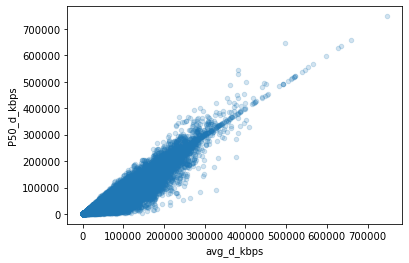

In [74]:
speed_data.plot.scatter(x='avg_d_kbps',y='P50_d_kbps',alpha=0.2)

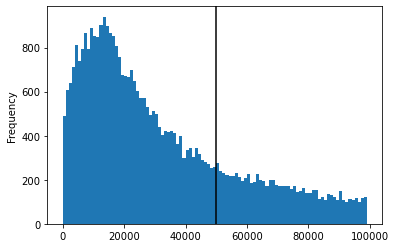

In [75]:
speed_data['avg_d_kbps'].plot.hist(bins=range(0,100000,1000))
plt.gca().axvline(50000,color='k')

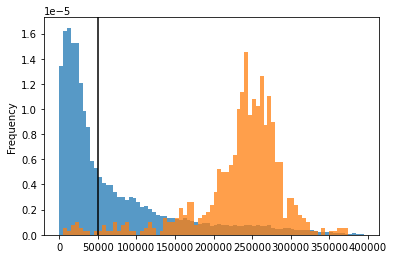

In [76]:
speed_data.loc[lambda s:~(s.PCCLASS == '4')]['P75_d_kbps'].plot.hist(bins=range(0,400000,5000), density=True, alpha=0.75)
speed_data.loc[lambda s:(s.PCCLASS == '4')]['P75_d_kbps'].plot.hist(bins=range(0,400000,5000), density=True,alpha=0.75)
plt.gca().axvline(50000,color='k')

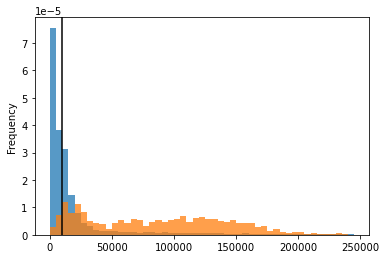

In [77]:
speed_data.loc[lambda s:pd.isna(s.PCCLASS)]['P75_u_kbps'].plot.hist(bins=range(0,250000,5000), density=True, alpha=0.75)
speed_data.loc[lambda s:~pd.isna(s.PCCLASS)]['P75_u_kbps'].plot.hist(bins=range(0,250000,5000), density=True, alpha=0.75)
plt.gca().axvline(10000,color='k')

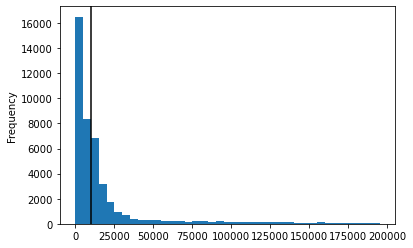

In [78]:
speed_data.loc[lambda s:pd.isna(s.PCPUID)]['P75_u_kbps'].plot.hist(bins=range(0,200000,5000))
plt.gca().axvline(10000,color='k')

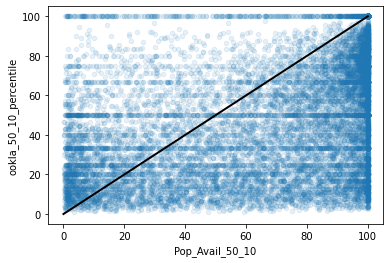

In [79]:
ax = speed_data.loc[lambda s:(s.Pop_Avail_50_10 > 0) & (s.ookla_50_10_percentile)].loc[lambda s:s.PCCLASS.isna()].plot.scatter(x='Pop_Avail_50_10', y='ookla_50_10_percentile', alpha=.1)
ax.plot([0,100], [0,100], color='k', lw=2);

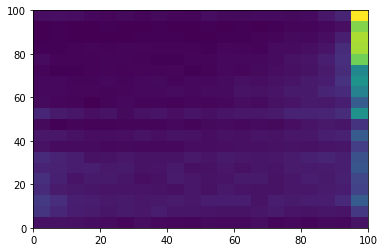

In [80]:
thing =speed_data.loc[lambda s:(s.Pop_Avail_50_10 > 0) & (s.ookla_50_10_percentile)]
plt.hist2d(thing['Pop_Avail_50_10'], thing['ookla_50_10_percentile'], bins=20, range=[(0,100),(0,100)]);

<AxesSubplot:>

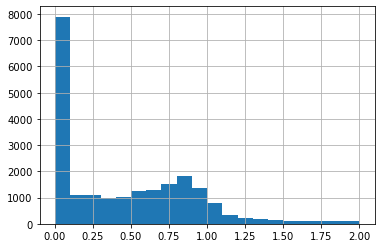

In [81]:
speed_data.loc[lambda s:s.Pop_Avail_50_10>0].apply(lambda s:s.ookla_50_10_percentile/s.Pop_Avail_50_10 if s.Pop_Avail_50_10 > 0 else 0, axis=1).hist(bins=20, range=[0,2])

<AxesSubplot:>

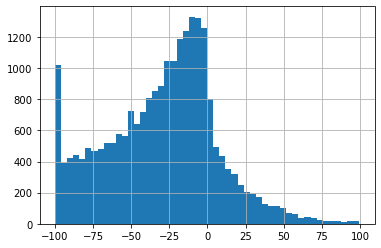

In [82]:
speed_data.loc[lambda s:s.Pop_Avail_50_10>0].apply(lambda s:s.ookla_50_10_percentile-s.Pop_Avail_50_10, axis=1).hist(bins=50)#, range=[0,2])


In [83]:
speed_data

,PCPUID,HEXUID_PCPUID,PRCODE,PCNAME,PCCLASS,Pop2016,TDwell2016_TLog2016,URDwell2016_RH2016,PHH_Count,Common_Type,...,ave_tests_per_tile,unique_devices,ave_devices_per_tile,num_tiles,Down_50_percentile,Up_10_percentile,ookla_50_10_percentile,min_year,max_year,connections
0,100792,NL47580528-100792,NL,St. John's,4,9896.147562,5058.332094,4318.056742,685.0,3.0,...,20.750000,1517.0,6.772321,224.0,89.732143,96.428571,89.732143,Q4 2021,Q3 2022,fixed
1,100792,NL47580529-100792,NL,St. John's,4,4252.819048,1648.265873,1558.259524,437.0,4.0,...,6.870588,341.0,2.005882,170.0,91.764706,95.294118,91.764706,Q4 2021,Q3 2022,fixed
2,100792,NL47710527-100792,NL,St. John's,4,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Data,No Data,No Data
3,100792,NL47430528-100792,NL,St. John's,4,2662.527342,1056.284918,1025.692964,149.0,3.0,...,14.592593,90.0,3.333333,27.0,100.000000,100.000000,100.000000,Q4 2021,Q3 2022,fixed
4,100792,NL47510528-100792,NL,St. John's,4,24029.650382,10449.110393,9692.839561,1684.0,3.0,...,19.819277,1889.0,5.689759,332.0,93.373494,98.192771,93.373494,Q4 2021,Q3 2022,fixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518090,None,BC53331204,BC,None,None,0.000000,0.000000,0.000000,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Data,No Data,No Data
518091,None,BC52891204,BC,None,None,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Data,No Data,No Data
518092,None,BC52661204,BC,None,None,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Data,No Data,No Data
518093,None,BC53111204,BC,None,None,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Data,No Data,No Data


In [84]:
speed_data.Pop2016.sum()

35151728.00000001

In [85]:
print("{:10,.0f} >50/10;\n{:10,.0f} <50/10;\n{:10,.0f} no data;\n{:10,.0f} all pop".format(
*[
    (speed_data['Pop2016']*speed_data['ookla_50_10_percentile']/100.0).sum(),
    (speed_data['Pop2016']*(100-speed_data['ookla_50_10_percentile'])/100.0).sum(),
    speed_data[speed_data['ookla_50_10_percentile'].isna()].Pop2016.sum(),
    speed_data.Pop2016.sum()
]
)
)

28,632,347 >50/10;
 6,250,188 <50/10;
   269,193 no data;
35,151,728 all pop


In [86]:
28_820_499/35_151_728*100

81.9888541468004

In [88]:
print("{:10,.0f} >50/10;\n{:10,.0f} <50/10;\n{:10,.0f} no data;\n{:10,.0f} all pop".format(
*[
    (rural_speed_data['Pop2016']*rural_speed_data['ookla_50_10_percentile']/100.0).sum(),
    (rural_speed_data['Pop2016']*(100-rural_speed_data['ookla_50_10_percentile'])/100.0).sum(),
    rural_speed_data[rural_speed_data['ookla_50_10_percentile'].isna()].Pop2016.sum(),
    rural_speed_data.Pop2016.sum(),
]
)
)

 2,825,528 >50/10;
 3,575,125 <50/10;
   177,345 no data;
 6,577,998 all pop


In [89]:
2_963_931/6_577_998*100

45.05825328618221

In [90]:
speed_data.columns

Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'geometry', 'avg_d_kbps', 'std_d_kbps',
       'min_d_kbps', 'P25_d_kbps', 'P50_d_kbps', 'P75_d_kbps', 'max_d_kbps',
       'avg_u_kbps', 'std_u_kbps', 'min_u_kbps', 'P25_u_kbps', 'P50_u_kbps',
       'P75_u_kbps', 'max_u_kbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       'Down_50_percentile', 'Up_10_percentile', 'ookla_50_10_percentile',
       'min_year', 'max_year', 'connections'],
      dtype='object')

In [91]:
print("{:10,.0f} >50/10;\n{:10,.0f} <50/10;\n{:10,.0f} no data;\n{:10,.0f} all pop".format(
*[
    (speed_data['Pop2016']*speed_data['Pop_Avail_50_10']/100).sum(),
    (speed_data['Pop2016']*(100-speed_data['Pop_Avail_50_10'])/100).sum(),
    speed_data[speed_data['Pop_Avail_50_10'].isna()].Pop2016.sum(),
    speed_data.Pop2016.sum()
]
)
)

32,458,702 >50/10;
 2,693,026 <50/10;
         0 no data;
35,151,728 all pop


In [92]:
32458702/35151728*100

92.33885173440122

In [93]:
print("{:10,.0f} >50/10;\n{:10,.0f} <50/10;\n{:10,.0f} no data;\n{:10,.0f} all pop".format(
*[
    (rural_speed_data['Pop2016']*rural_speed_data['Pop_Avail_50_10']/100.0).sum(),
    (rural_speed_data['Pop2016']*(100-rural_speed_data['Pop_Avail_50_10'])/100.0).sum(),
    rural_speed_data[rural_speed_data['Pop_Avail_50_10'].isna()].Pop2016.sum(),
    rural_speed_data.Pop2016.sum(),
]
)
)

 4,108,512 >50/10;
 2,469,486 <50/10;
         0 no data;
 6,577,998 all pop


In [94]:
4_108_512/6_577_998*100

62.45839539628927